# 15. Calibration using matching sections

In notebook 14 we showed how you can take splices or connectors within your calibration into account. To then calibrate the cable we used reference sections on both sides of the splice. If these are not available, or in other cases where you have a lack of reference sections, matching sections can be used to improve the calibration.

For matching sections you need two sections of fiber than you know will be the exact same temperature. This can be, for example, in duplex cables or twisted pairs of cable.

### Demonstration
To demonstrate matching sections, we'll load the same dataset that was used in previous notebooks, and modify the data to simulate a lossy splice, just as in notebook 14.

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3.7/typing.py:845: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 110))  # only calibrate parts of the fiber


sections = {
    'probe1Temperature': [slice(7.5, 17.)],  # cold bath
    'probe2Temperature': [slice(24., 34.)],  # warm bath
    }
ds.sections = sections

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


Again, we introduce a step loss in the signal strength at x = 50 m. For the forward channel, this means all data beyond 50 meters is reduced with a 'random' factor. For the backward channel, this means all data up to 50 meters is reduced with a 'random' factor.

In [3]:
ds['st'] = ds.st.where(ds.x < 50, ds.st*.8)
ds['ast'] = ds.ast.where(ds.x < 50, ds.ast*.82)

ds['rst'] = ds.rst.where(ds.x > 50, ds.rst*.85)
ds['rast'] = ds.rast.where(ds.x > 50, ds.rast*.81)

We will first run a calibration without adding the transient attenuation location or matching sections. A big jump in the calibrated temperature is visible at x = 50. 

As all calibration sections are before 50 meters, the first 50 m will be calibrated correctly.

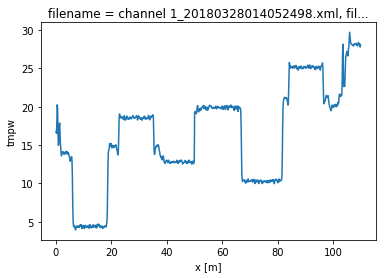

In [4]:
ds_a = ds.copy(deep=True)

st_var, resid = ds_a.variance_stokes(st_label='st')
ast_var, _ = ds_a.variance_stokes(st_label='ast')
rst_var, _ = ds_a.variance_stokes(st_label='rst')
rast_var, _ = ds_a.variance_stokes(st_label='rast')

ds_a.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_a.isel(time=0).tmpw.plot(label='calibrated')

Now we run a calibration, adding the keyword argument '**transient_asym_att_x**', and provide a list of floats containing the locations of the splices. In this case we only add a single one at x = 50 m.

We will also define the matching sections of cable. The matching sections have to be provided as a list of tuples. A tuple per matching section. Each tuple has three items, the first two items are the slices of the sections that are matching. The third item is a bool and is True if the two sections have a reverse direction (as in the "J-configuration").

In this example we match the two cold baths to each other.

After running the calibration you will see that by adding the transient attenuation and matching sections the calibration returns the correct temperature, without the big jump.

*In single-ended calibration the keyword is called '**transient_att_x**'.*

/home/bart/git/python-dts-calibration/.tox/docs/lib/python3.7/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


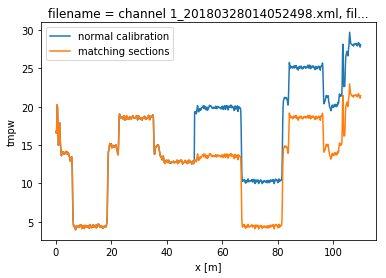

In [5]:
matching_sections = [
    (slice(7.5, 17.6), slice(69, 79.1), False)
]

st_var, resid = ds.variance_stokes(st_label='st')
ast_var, _ = ds.variance_stokes(st_label='ast')
rst_var, _ = ds.variance_stokes(st_label='rst')
rast_var, _ = ds.variance_stokes(st_label='rast')

ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    transient_asym_att_x=[50.],
    matching_sections=matching_sections,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_a.isel(time=0).tmpw.plot(label='normal calibration')
ds.isel(time=0).tmpw.plot(label='matching sections')
plt.legend()